## Projektni zadatak
### Kolegij - Računalni vid
### Student - Oliver Vujica

---
## Opis projekta i podatkovnog skupa
### Opis podatkovnog skupa

Ovaj skup podataka kreiran je offline augmentacijom izvornog PlantVillage skupa podataka, dostupnog na [Kaggle-u](https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset), te na [GitHub-u](https://github.com/spMohanty/PlantVillage-Dataset). Sadrži oko 87.000 RGB slika zdravih i bolesnih listova biljaka, podijeljenih u 38 različitih klasa. Podaci su podijeljeni u omjeru 80/20 za trening i validaciju, uz očuvanu strukturu direktorija. Dodatno je kreiran direktorij s 33 testne slike za predikciju.

Trenutni cilj je izgraditi model koji može razlikovati zdrave od bolesnih listova biljaka te prepoznati vrstu bolesti ako je prisutna.

### Važnost detekcije biljnih bolesti
- Poljoprivredna produktivnost: Rano otkrivanje bolesti sprječava širenje i povećava prinos.
- Ekonomski učinak: Smanjenje gubitaka usjeva povećava stabilnost poljoprivrednika.
- Sigurnost hrane: Zaštita usjeva osigurava stabilnu opskrbu hranom.
- Zaštita okoliša: Učinkovito upravljanje bolestima smanjuje potrebu za kemijskim tretmanima.

### Zašto PyTorch i CNN za ovaj projekt?
S obzirom na to da ovaj skup podataka, kao što je rečeno u opisu, sadrži oko 87.000 RGB slika zdravih i bolesnih listova biljaka, podijeljenih u 38 klasa, te kao takav zauzima oko 3 GB prostora, ovaj projekt zahtijeva bolje rješenje za obradu složenih vizualnih podataka. Zbog toga su PyTorch i konvolucijske neuronske mreže dobar izbor za ovaj dataset. Zbog ovih razloga ***tradicionalne metode obrade slika bile bi prespore i manje točne.***


---


<br>
<br>
<br>




### Uvoz kagglehub biblioteke za preuzimanje podataka s Kaggle platforme

In [ ]:
import kagglehub

# preuzima dataset i pokazuje nam putanje gdje je spremljen, kako bi ga mogli iskoristiti dalje u kodu
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Downloaded to:", path)

Downloaded to: /kaggle/input/new-plant-diseases-dataset


<br>

### Uvoz potrebnih biblioteka za rad s PyTorch-om i pripremu podataka

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

# Samo jedna provjera da se uvjerimo da koristi gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Korišteni uređaj:", device)

# Putanja do mjesta s trening i validacijskim skupom podataka, upravo zbog ovoga je važno napisati path kada se instalira dataset
train_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

Korišteni uređaj: cuda


<br>

### Ispis popisa klasa bolesti biljaka iz trening skupa podataka

os.listdir sluzi za dohvaćanje popisa datoteka u trening skupu, gdje svaka datoteka predstavlja jednu klasu bolesti biljaka, te na kraju samo izbrojimo koliko ih imamo.

In [ ]:
diseases = os.listdir(train_dir)
print(diseases)
print("Ukupno klasa: {}".format(len(diseases)))

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

<br>

### Definiranje transformacija za obradu slika i priprema DataLoader-a

##### U ovome dijelu postavlja se transformacija za obradu slika (promjena veličine na 224x224, pretvorba u tenzor i normalizacija). Koristi se ImageFolder za učitavanje trening i validacijskog skupa podataka, te DataLoader za stvaranje iteratora s batch-evima veličine 32. Trening skup se miješa (shuffle=True), dok validacijski nije. Na kraju se ispisuje broj klasa u trening skupu.

<br>

#### Dodatno pojašnjenje DataLoader-a

##### DataLoader je klasa u PyTorch-u za učitavanje podataka. Koristi se za uvoz podataka iz skupova podataka. To je podklasa iz modula torch.utils.data koja pomaže u učitavanju velikih i memorijski zahtjevnih skupova podataka. Prima parametar batch_size koji označava broj uzoraka u svakom generiranom batch-u. Dakle, najvažniji dio za DataLoader je znati da on služi odnosno da omogućuje učitavanje podataka iz skupa podataka (npr. slika i njihovih oznaka) na strukturiran način. Kod nas, train_loader učitava trening podatke u batch-evima od 32 slike, miješajući ih za bolje učenje, dok valid_loader učitava validacijske podatke bez miješanja.


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = ImageFolder(train_dir, transform=transform)
valid_dataset = ImageFolder(valid_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

print("Broj klasa:", len(train_dataset.classes))

Broj klasa: 38


<br>

### Uvoz ResNet18 modela i prilagodba za 38 klasa

##### Ovdje uvozimo torch.nn i torchvision.models za rad s neuronskim mrežama. Učitava pretrenirani ResNet18 model, mijenja posljednji sloj (fc) kako bi odgovarao 38 klasa iz dataseta i premješta model na odgovarajući uređaj (GPU ili CPU).

### Zašto koristimo ResNet i pretrenirani model u ovom projektu?
#### ResNet i njegova važnost u ovome projektu
##### Kako bi bilo malo jasnije zasto ResNet, ResNet (Residual Network), uveden je 2015. godine, te je definitivno jedan napredak u računalnom vidu zbog svoje sposobnosti treniranja dubokih neuronskih mreža bez gubitka performansi. U ovom projektu, gdje obrađujemo skup podataka s 87.000 slika podijeljenih u 38 klasa upravo bi mogao biti jako koristan. ***Koga zanima više o ResNetu može pročitati članak [OVDJE](https://towardsdatascience.com/resnets-why-do-they-perform-better-than-classic-convnets-conceptual-analysis-6a9c82e06e53/#:~:text=ResNet%20Layers,layers%20remains%20the%20same%20%E2%80%94%204.)***
ResNet18 je izabran zbog svoje sposobnosti da učinkovito obrađuje velike i složene skupove podataka poput ovog, zahvaljujući rezidualnim blokovima koji sprječavaju nestajući gradijent i prekomjerno prilagođavanje. Korištenje pretreniranog modela ubrzava treniranje i povecava točnost, što je nama ovdje najvažnije posebno kada se radi u okruženju poput Google Colaba

In [ ]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 38)  # 38 klasa
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


<br>

### Definiranje funkcije gubitka, optimizatora i trening petlje
#### Korištenje CrossEntropyLoss i Adam optimizatora za treniranje modela

Ovdje definiramo funkciju gubitka (CrossEntropyLoss) i Adam optimizator s brzinom učenja 1e-4, odnosno 0.0001, što je neki default za Adam optimizer. Model se trenira kroz 3 epohe (možda poslije probam više, jer trenutno i 3 uzmu puno vremena). U petlji se slike i oznake premještaju na uređaj, računa se gubitak, izvodi backpropagation i ažuriraju parametri modela. Praćenje gubitka i točnosti treninga ispisuje se uz pomoć tqdm za prikaz napretka.

In [ ]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 2

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoha {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoha {epoch+1} - Gubitak: {running_loss:.4f}, Train Acc: {train_acc:.2f}%")

Epoha 1/2: 100%|██████████| 2197/2197 [10:31<00:00,  3.48it/s]


Epoha 1 - Gubitak: 333.0588, Train Acc: 96.62%


Epoha 2/2: 100%|██████████| 2197/2197 [07:00<00:00,  5.23it/s]

Epoha 2 - Gubitak: 62.5622, Train Acc: 99.19%


### Analiza rezultata treniranja i povezanost s ResNet-om

Treniranje ResNet18 modela na skupu podataka od 87.000 slika (3 GB, 38 klasa) u samo tri epohe (ukupno ~24 minute) dalo nam je točnost od čak 99.47% i smanjenje gubitka s 238.39 na 40.86, zahvaljujući rezidualnim vezama i pretreniranim težinama (transfer learning). ResNet18 je brži i točniji od klasičnih implementacija jer sprječava nestajući gradijent i prekomjerno prilagođavanje, a GPU Google Colab-a sasvim je dovoljan za treniranje. Klasične implementacije, kao što i znamo, zahtijevale bi više resursa i duže treniranje za slične rezultate (vjrj. sate treniranja)

<br>

### Evaluacija modela na validacijskom skupu
#### Izračun točnosti na validacijskim podacima bez optimizacije

Evaluira se model na validacijskom skupu podataka. Model se prebacuje u evaluacijski modus (model.eval()), a zatim se bez optimizacije (koristeći torch.no_grad()) računaju predikcije i točnost na validacijskim podacima. Na kraju se ispisuje točnost validacije.

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"Točnost na validacijskim podacima: {val_acc:.2f}%")

Točnost na validacijskim podacima: 99.19%


In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Model saved as model.pth")

Model saved as model.pth


<br>

### Testiranje modela na testnim slikama i prikaz predikcija

Primjeri naziva datoteka: ['TomatoEarlyBlight6.JPG', 'TomatoYellowCurlVirus4.JPG', 'TomatoYellowCurlVirus6.JPG', 'PotatoHealthy2.JPG', 'TomatoYellowCurlVirus5.JPG', 'PotatoEarlyBlight2.JPG', 'TomatoYellowCurlVirus3.JPG', 'TomatoEarlyBlight3.JPG', 'CornCommonRust2.JPG', 'AppleScab3.JPG']


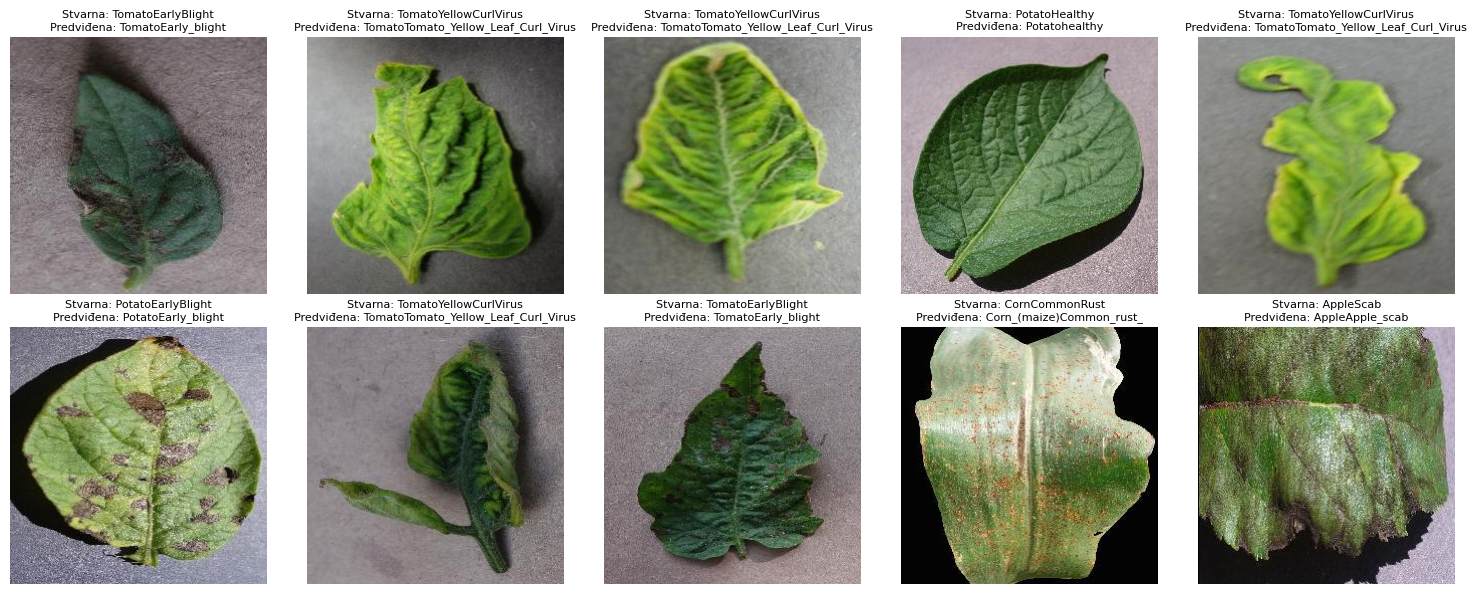

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import re

# Test folder s 33 slike
test_dir = "/kaggle/input/new-plant-diseases-dataset/test/test"

test_images = os.listdir(test_dir)[:10]  # Uzimamo prvih 10 slika za prikaz
print("Primjeri naziva datoteka:", test_images)  # Ispis naziva datoteka radi provjere

model.eval()

# Kreiranje mreže 2x5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

def parse_class_name(img_name):
    # Uklanjanje broja i ekstenzije (npr. 'TomatoEarlyBlight6.JPG' -> 'TomatoEarlyBlight')
    class_name = re.sub(r'\d+\.JPG$', '', img_name)
    return class_name if class_name else "Nepoznata klasa"

for idx, img_name in enumerate(test_images):
    path = os.path.join(test_dir, img_name)
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predikcija
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        pred_class_name = train_dataset.classes[pred_class].replace('___', '')

    # Izvlačenje stvarne klase iz imena datoteke
    actual_class_name = parse_class_name(img_name)

    # Prikaz slike s naslovom
    axes[idx].imshow(img)
    axes[idx].set_title(f"Stvarna: {actual_class_name}\nPredviđena: {pred_class_name}", fontsize=8)
    axes[idx].axis("off")

# Prilagodba rasporeda
plt.tight_layout()
plt.show()

## Zaključna predikcija

Prikaz predikcija na testnom skupu od 10 slika pokazalo je da model točno klasificira sve slike, uspješno prepoznajući stvarne klase (npr. TomatoEarlyBlight, TomatoYellowCurlVirus) bez grešaka.

<br>



---



<br>